# Question
Are the sensitivities that I'm trying to use to train my networks actually correct? That is, does py-mpc give me the right sensitivities for piecewise affine systems?

In [2]:
using Plots

In [3]:
include("../../pympc.jl")

Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [4]:
col(x::AbstractArray) = convert(Matrix, reshape(x, length(x), 1))

col (generic function with 1 method)

# Method
I'm going to create a piecewise affine system with two pieces. They'll differ only in their affine term:

In [42]:
t_s = 0.1
method = "explicit_euler"

A_1 = [
    0. 1
    -1 0
]
B_1 = [0 1]'

S_1 = PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A_1, B_1, 0.1 .+ zeros(2, 1), t_s, method)
S_2 = PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A_1, B_1, -0.1 .+ zeros(2, 1), t_s, method)
S = [S_1, S_2]

# state bounds
x_max = [1., 1]
x_min = -x_max

# state domain n.1
lhs_1 = [1., 0]
rhs_1 = [0.]
X_1 = PyMPC.geometry.Polytope[:from_bounds](col(x_min), col(x_max))
X_1[:add_facets](lhs_1, col(rhs_1))
X_1[:assemble]()

# state domain n.2
lhs_2 = [-1., 0]
rhs_2 = [0.]
X_2 = PyMPC.geometry.Polytope[:from_bounds](col(x_min), col(x_max))
X_2[:add_facets](lhs_2, col(rhs_2))
X_2[:assemble]()

# list of state domains
X = [X_1, X_2]

# input domain
u_max = [10.]
u_min = -u_max
U = PyMPC.geometry.Polytope[:from_bounds](col(u_min), col(u_max))
U[:assemble]()
U = [U, U]

pwa_sys = PyMPC.dynamical_systems.DTPWASystem[:from_orthogonal_domains](S, X, U)

PyObject <pympc.dynamical_systems.DTPWASystem object at 0x142138590>

In [43]:
# controller parameters
N = 4
Q = 10 * eye(size(A_1, 1))
R = eye(size(B_1, 2))
objective_norm = "two"

# terminal set and cost
P, K = PyMPC.dynamical_systems.dare(S[2][:A], S[2][:B], Q, R)
# X_N = PyMPC.dynamical_systems.moas_closed_loop(S[2][:A], S[2][:B], K, X[2], U[2])

# hybrid controller
controller = PyMPC.control.MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X[2])

PyObject <pympc.control.MPCHybridController instance at 0x143736b90>

`run-mpc` will try to extract the sensitivity ($\frac{\partial u}{\partial x_i}$) from py-mpc

In [44]:
function run_mpc(controller, x0)
    u_feedforward, x_trajectory, cost, switching_sequence = controller[:feedforward](col(x0))
    if isnan(u_feedforward[1][1])
        return u_feedforward[1], fill(NaN, length(u_feedforward[1]), length(x0)), x_trajectory
    end
    condensed = controller[:condense_program](switching_sequence)
    u, cost = condensed[:solve](col(x0))
    active_set = condensed[:get_active_set](col(x0), u)
    u_offset, u_linear = condensed[:get_u_sensitivity](active_set)
    u_feedforward[1], u_linear, x_trajectory
end

run_mpc (generic function with 1 method)

u_linear = [-1.72864 -3.43655; -0.79093 -2.42843; -0.128299 -1.67298; 0.328197 -1.11088]



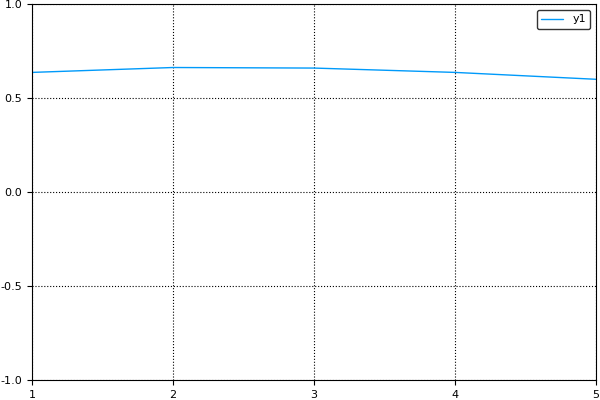

In [45]:
x0 = 2 .* (rand(2) .- 0.5)
u_ff, u_linear, x_traj = run_mpc(controller, x0)
@show u_linear
plot([x[1] for x in x_traj], ylim=(x_min[1], x_max[1]))

# Experiment
Run 200 iterations of the MPC controller. For each iteration, record the predicted sensitivity from `py-mpc`. Also, iterate through each component of `x0` and perturb it slightly, and record the measured sensitivity through finite differencing. 

In [46]:
results = []

for j in 1:200
    x0 = 2 .* (rand(2) .- 0.5)
    u_ff, u_linear, x_traj = run_mpc(controller, x0)
    if any(isnan, u_ff)
        continue
    end
    J = u_linear[1:length(u_ff), :]
    J_measured = zeros(x0)
    for i in 1:length(x0)
        delta = zeros(x0)
        delta[i] = 1e-3
        x2 = x0 .+ delta
        u_ff2, _, _ = run_mpc(controller, x2)
        J_measured[i] = (u_ff2[1] - u_ff[1]) / delta[i]
#         if !any(isnan, u_ff2)
#             try
#                 @assert isapprox(u_ff2, u_ff .+ J * delta, atol=1e-4)
#             catch
#                 @show u_ff2, u_ff .+ J * delta
#             end
#         end
    end
    if !any(isnan, J_measured)
        push!(results, (J, J_measured))
    end
end
        
    

In [47]:
results

128-element Array{Any,1}:
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-24.2013 -9.31576], [-24.2013, -9.31576])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-49.0088 -13.3774], [-49.0088, -13.3774])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ⋮                                          
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-24.2013 -9.31576], [-24.2013, -9.31576])
 ([-24.2013 -9.31576], [-24.2013, -9.31576])
 ([-1.72864 -3.43655], [-1.72864, -3.43655])
 ([-1.72864 -3.43655], [-1.72

# Analysis
Plot predicted vs. measured sensitivity. 


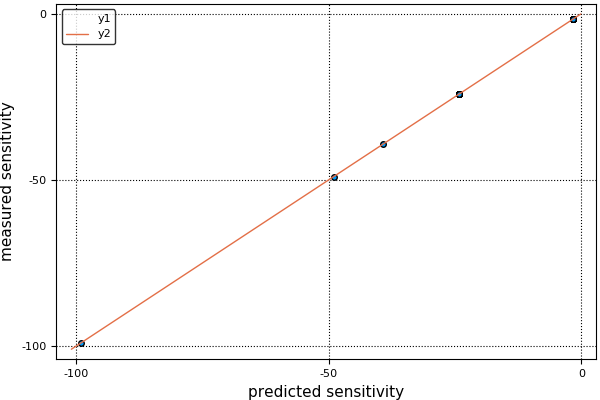

In [48]:
i = 1
plt = plot([r[1][i] for r in results], [r[2][i] for r in results], line=nothing, marker=:circle,
xlabel="predicted sensitivity", ylabel="measured sensitivity")
plot!(plt, identity)


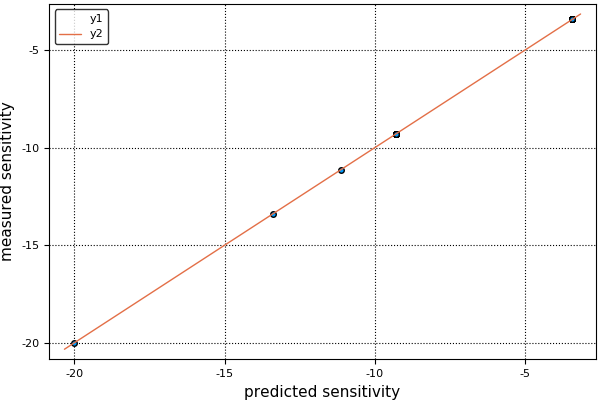

In [49]:
i = 2
plt = plot([r[1][i] for r in results], [r[2][i] for r in results], line=nothing, marker=:circle,
xlabel="predicted sensitivity", ylabel="measured sensitivity")
plot!(plt, identity)